# Imports

In [1]:
import numpy as np
import pandas as pd
import pkg_resources
import itertools
import shap 
import math
import multiprocessing
from scipy.stats import norm
import matplotlib.pyplot as plt
import plotnine
from plotnine import *
plotnine.options.figure_size = (20, 10)

from xgboostlss.model import *
from xgboostlss.distributions.Expectile import Expectile
from xgboostlss.datasets.data_loader import load_simulated_data

# Data

In [2]:
# The data is a simulated Gaussian as follows, where x is the only true feature and all others are noise variables
    # loc = 10
    # scale = 1 + 4*((0.3 < x) & (x < 0.5)) + 2*(x > 0.7)

train, test = load_simulated_data()
n_cpu = multiprocessing.cpu_count()

X_train, y_train = train.iloc[:,1:],train.iloc[:,0]
X_test, y_test = test.iloc[:,1:],test.iloc[:,0]

dtrain = xgb.DMatrix(X_train, label=y_train, nthread=n_cpu)
dtest = xgb.DMatrix(X_test, nthread=n_cpu)

# Expectile Specification

In [3]:
distribution = Expectile  
distribution.expectiles = [0.05, 0.95]     # Expectiles to be estimated: needs to be a list of at least two expectiles.
distribution.stabilize = "None"            # Option to stabilize Gradient/Hessian. Options are "None", "MAD", "L2".

In [6]:
np.random.seed(123)

# Specifies the parameters and their value range. The structure is as follows: "hyper-parameter": [lower_bound, upper_bound]. Currently, only the following hyper-parameters can be optimized:
params = {"eta": [1e-5, 1],                   
          "max_depth": [1, 10],
          "gamma": [1e-8, 40],
          "subsample": [0.2, 1.0],
          "colsample_bytree": [0.2, 1.0],
          "min_child_weight": [0, 500]
         }

opt_params = xgboostlss.hyper_opt(params,
                                  dtrain=dtrain,
                                  dist=distribution,
                                  num_boost_round=500,       # Number of boosting iterations.
                                  max_minutes=120,           # Time budget in minutes, i.e., stop study after the given number of minutes.
                                  n_trials=None,             # The number of trials. If this argument is set to None, there is no limitation on the number of trials.
                                  silence=False)             # Controls the verbosity of the trail, i.e., user can silence the outputs of the trail.

[I 2021-12-22 11:04:30,803] A new study created in memory with name: XGBoostLSS-HyperOpt
C:\Users\Alexander\.julia\v0.6\Conda\deps\usr\envs\xgboostlss\lib\site-packages\optuna\progress_bar.py:47: ExperimentalWarning: Progress bar is experimental (supported from v1.2.0). The interface can change in the future.


0it [00:00, ?it/s]

[I 2021-12-22 11:05:40,996] Trial 0 finished with value: 955.2924987 and parameters: {'eta': 0.030363087280807707, 'max_depth': 3, 'gamma': 1.5074442732613943e-06, 'subsample': 0.4857160809399238, 'colsample_bytree': 0.6366741608938994, 'min_child_weight': 211}. Best is trial 0 with value: 955.2924987.
[I 2021-12-22 11:05:55,576] Trial 1 finished with value: 1115.6083861000002 and parameters: {'eta': 0.8013476947482925, 'max_depth': 7, 'gamma': 0.0004148938237251032, 'subsample': 0.3759312069680463, 'colsample_bytree': 0.3474570556327573, 'min_child_weight': 365}. Best is trial 0 with value: 955.2924987.
[I 2021-12-22 11:08:22,621] Trial 2 finished with value: 1748.2885987000002 and parameters: {'eta': 0.0015590542353378792, 'max_depth': 1, 'gamma': 6.638115717563432e-05, 'subsample': 0.6559438243964698, 'colsample_bytree': 0.26827872970098154, 'min_child_weight': 87}. Best is trial 0 with value: 955.2924987.
[I 2021-12-22 11:11:05,999] Trial 3 finished with value: 1018.4372072999997 a

# Model Training

In [5]:
np.random.seed(123)

n_rounds = opt_params["opt_rounds"]
del opt_params["opt_rounds"]

# Train Model with optimized hyper-parameters
xgboostlss_model = xgboostlss.train(opt_params,
                                    dtrain,
                                    dist=distribution,
                                    num_boost_round=n_rounds)

# Prediction

In [6]:
# Extract predicted expectiles
pred_expectile = xgboostlss.predict(xgboostlss_model, 
                                    dtest, 
                                    dist=distribution,
                                    pred_type="expectiles")

In [7]:
pred_expectile.head()

,expectile_0.05,expectile_0.95
0,6.585015,13.118120
1,6.775733,13.156876
2,8.681597,11.383493
3,4.095777,15.101906
4,6.472260,13.515471


# SHAP Interpretability

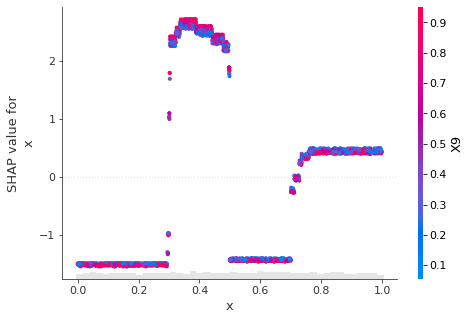

In [10]:
# Partial Dependence Plot of how x acts on selected expectile 
xgboostlss.expectile_plot(xgboostlss_model, 
                          X_test, 
                          dist=distribution,
                          expectile="0.95",
                          feature="x", 
                          plot_type="Partial_Dependence")

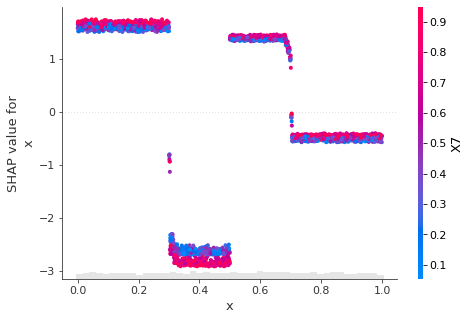

In [11]:
# Partial Dependence Plot of how x acts on selected expectile 
xgboostlss.expectile_plot(xgboostlss_model, 
                          X_test, 
                          dist=distribution,
                          expectile="0.05",
                          feature="x", 
                          plot_type="Partial_Dependence")

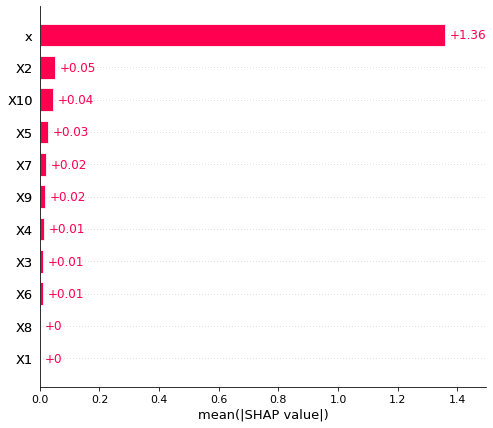

In [15]:
# Global Feature Importance of selected expectile 
xgboostlss.expectile_plot(xgboostlss_model, 
                          X_test, 
                          dist=distribution,
                          expectile="0.95",
                          feature="x", 
                          plot_type="Feature_Importance")

# Plot of Actual vs. Predicted Expectiles

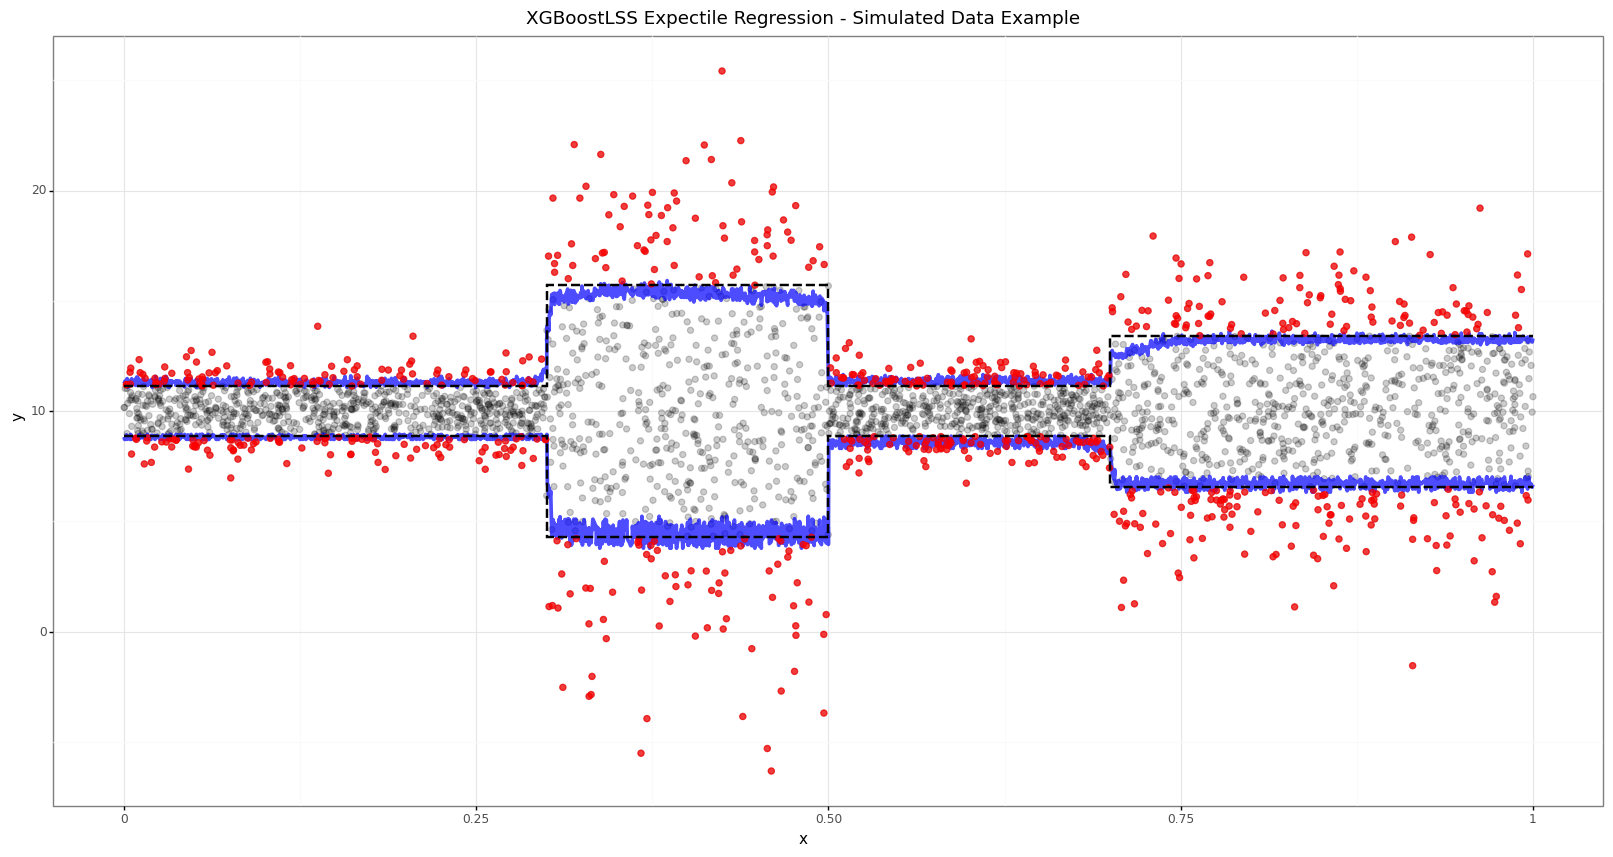

<ggplot: (122691977960)>

In [14]:
np.random.seed(123)

###
# Actual Expectiles
###
y_loc = np.array([10])
y_scale = np.array([1 + 4*((0.3 < test["x"].values) & (test["x"].values < 0.5)) + 2*(test["x"].values > 0.7)])
tau_lower = np.array([distribution.expectiles[0]])
tau_upper = np.array([distribution.expectiles[1]])

# Calculates exact expecitles assuming a Normal distribution
expectile_lb = Expectile.expect_norm(tau_lower,
                                     m=y_loc,
                                     sd=y_scale).reshape(-1,)

# Calculates exact expecitles assuming a Normal distribution
expectile_ub =  Expectile.expect_norm(tau_upper,
                                      m=y_loc,
                                      sd=y_scale).reshape(-1,)

test["expect"] = np.where(test["y"].values < expectile_lb, 0, np.where(test["y"].values < expectile_ub, 1, 2))
test["alpha"] = np.where(test["y"].values <= expectile_lb, 1, np.where(test["y"].values >= expectile_ub, 1, 0))
df_expectiles = test[test["alpha"] == 1]

# Lower Bound
yl = list(set(expectile_lb))
yl.sort()
yl = [yl[2],yl[0],yl[2],yl[1],yl[1]]
sfunl = pd.DataFrame({"x":[0, 0.3, 0.5, 0.7, 1],
                      "y":yl})

# Upper Bound
yu = list(set(expectile_ub))
yu.sort()
yu = [yu[0],yu[2],yu[0],yu[1],yu[1]]
sfunu = pd.DataFrame({"x":[0, 0.3, 0.5, 0.7, 1],
                      "y":yu})



###
# Forecasted Expectiles
###
test["lb"] = pred_expectile.iloc[:,0]
test["ub"] = pred_expectile.iloc[:,1]



###
# Plot
###
(ggplot(test,
        aes("x",
            "y")) + 
 geom_point(alpha = 0.2, color = "black", size = 2) + 
 theme_bw() + 
 theme(legend_position="bottom",
       plot_title = element_text(hjust = 0.5)) +
 labs(title = "XGBoostLSS Expectile Regression - Simulated Data Example")  + 
 geom_line(aes("x",
               "ub"),
           size = 1.5,
           color = "blue", 
           alpha = 0.7) + 
 geom_line(aes("x",
               "lb"),
           size = 1.5,
           color = "blue", 
           alpha = 0.7) + 
 geom_point(df_expectiles,
            aes("x",
                "y"), 
            color = "red", 
            alpha = 0.7,
            size = 2) + 
 geom_step(sfunl,
           aes("x",
               "y"), 
           size = 1, 
           linetype = "dashed")  + 
 geom_step(sfunu,
           aes("x",
               "y"), 
           size = 1, 
           linetype = "dashed") 
)